## 1. Pré-processamento

O *dataset* original consistia em uma série temporal com **2.356.110 instâncias** e seis colunas principais (`date`, `state`, `name`, `code`, `cases`, `deaths`). Para atender aos objetivos de **aprendizado não supervisionado**, foi necessário transformar esses dados brutos em uma representação **descritiva e consolidada por município**.

#### Limpeza e Agregação dos Dados

Como cada município aparecia repetidamente ao longo do tempo, realizamos etapas de agregação para sintetizar seu perfil epidemiológico:

- **Tratamento dos dados:** remoção de valores nulos, registros em branco e colunas irrelevantes para a análise de *clusters*.
- **Engenharia de atributos (*feature engineering*):**
  - `total_cases`: total acumulado de casos por município.
  - `peak_cases`: maior número de casos registrados em um único dia, representando a intensidade do pico pandêmico local.

Essas transformações permitiram capturar tanto a magnitude quanto a dinâmica da disseminação da doença em cada localidade.

### Preparação para os Algoritmos de *Machine Learning*

Considerando que os algoritmos de *Machine Learning* operam exclusivamente sobre dados numéricos e são sensíveis à escala das variáveis, aplicamos as seguintes técnicas:

- **One-Hot Encoding:** conversão de variáveis categóricas em representações numéricas, possibilitando o seu uso nos modelos.
- **Normalização (`StandardScaler`):** padronização das variáveis numéricas.

#### &emsp; 1.1 Baixando o dataset

In [1]:
# Intalação do gdown para pegar .csv bruto
%pip install gdown


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Baixar o .csv bruto
import os.path as path
if not path.exists('./data/brazil_covid19_cities.csv'):
  print("Baixando arquivo...")
  !gdown "1sg9QK4g8QKCNgvfi6iNowcP75KNNkxUY" -O ./data/brazil_covid19_cities.csv

In [3]:
# Importação do csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import umap
df = pd.read_csv('./data/brazil_covid19_cities.csv')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### &emsp; 1.2 Modelando os dados 

In [4]:
# Renomear coluna name para city
df = df.rename(columns={'name': 'city'})

In [5]:
# Transforma a coluna `date` em um objeto DateTime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['city', 'date'])

In [6]:
# Garantir que casos e mortes são numéricos
df['cases'] = pd.to_numeric(df['cases'], errors='coerce')
df['deaths'] = pd.to_numeric(df['deaths'], errors='coerce')

df = df.dropna(subset=['city', 'cases', 'deaths'])

In [7]:
# Adição de variáveis por cidade e estado
features_city = df.groupby(['city', 'state']).agg({
  'cases': ['max', 'mean', 'std'],
  'deaths': ['max', 'mean', 'std'],
  'date': 'count'
})

features_city.columns = [
  'total_cases',
  'mean_cases',
  'std_cases',
  'total_deaths',
  'mean_deaths',
  'std_deaths',
  'days_recorded'
]

features_city.head()

,,total_cases,mean_cases,std_cases,total_deaths,mean_deaths,std_deaths,days_recorded
city,state,,,,,,,
Abadia de Goiás,GO,1351.0,558.153664,426.181817,28,7.565012,7.530658,423
Abadia dos Dourados,MG,375.0,118.761229,119.465862,14,2.687943,4.138253,423
Abadiânia,GO,400.0,147.659574,105.898626,27,10.801418,8.029761,423
Abaetetuba,PA,7659.0,3646.444444,2098.725146,210,104.628842,48.581654,423
Abaeté,MG,1019.0,248.574468,312.806079,26,5.224586,6.855251,423


In [8]:
# Adição de coluna `death_rate` (taxa de mortalidade)
features_city['death_rate'] = (
    features_city['total_deaths'] / features_city['total_cases']
)


In [9]:
# Crescimento dos casos
df['new_cases'] = df.groupby(['city', 'state'])['cases'].diff().fillna(0)

growth = df.groupby(['city', 'state'])['new_cases'].mean().rename('mean_daily_growth')
features_city = features_city.join(growth)

In [10]:
# Dia do primeiro caso
first_case = df[df['cases'] > 0].groupby(['city','state'])['date'].min()
first_case = (first_case - df['date'].min()).dt.days
first_case = first_case.rename('days_until_first_case')

features_city = features_city.join(first_case)

In [11]:
# Remoção de registros com dados faltosos
features_city = features_city.dropna()

In [12]:
# Reset de índices
features_city = features_city.reset_index()

In [13]:
# Remoção do do campo `city`
features_city.drop('city', axis=1, inplace=True)

In [14]:
# Aplicando one-hot encode no campo `state`
features_city = pd.get_dummies(features_city, columns=['state'])

In [15]:
# Finalização do DataFrame tratado
df = features_city.copy()

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_cases            5570 non-null   float64
 1   mean_cases             5570 non-null   float64
 2   std_cases              5570 non-null   float64
 3   total_deaths           5570 non-null   int64  
 4   mean_deaths            5570 non-null   float64
 5   std_deaths             5570 non-null   float64
 6   days_recorded          5570 non-null   int64  
 7   death_rate             5570 non-null   float64
 8   mean_daily_growth      5570 non-null   float64
 9   days_until_first_case  5570 non-null   int64  
 10  state_AC               5570 non-null   bool   
 11  state_AL               5570 non-null   bool   
 12  state_AM               5570 non-null   bool   
 13  state_AP               5570 non-null   bool   
 14  state_BA               5570 non-null   bool   
 15  stat

## Estruturação dos Dados pós-processamento



Após as etapas de limpeza, o conjunto de dados consolidado passou a contar com 5.570 instâncias. Isso representa a totalidade dos municípios brasileiros e 37 colunas estruturadas.

| Categoria                          | Métrica / Atributo           | Descrição                                                                 |
|-----------------------------------|------------------------------|---------------------------------------------------------------------------|
| **Magnitude e Dispersão**          | `total_cases`                | Total acumulado de casos por município.                                   |
|                                   | `mean_cases`                 | Média diária de casos registrados ao longo do período analisado.          |
|                                   | `std_cases`                  | Desvio padrão dos casos diários, indicando a variabilidade do contágio.   |
|                                   | `total_deaths`               | Total acumulado de óbitos por município.                                  |
|                                   | `mean_deaths`                | Média diária de óbitos registrados no período.                             |
| **Indicadores Epidemiológicos**    | `death_rate`                 | Taxa de letalidade por município (óbitos / casos confirmados).            |
| **Avançados**                     | `mean_daily_growth`          | Velocidade média de crescimento diário dos casos.                          |
|                                   | `days_until_first_case`      | Número de dias até o registro do primeiro caso no município.               |
| **Localização Geográfica**         | `state_AC` – `state_TO`      | Variáveis binárias geradas por One-Hot Encoding para representar os estados |
|                                   |                              | brasileiros, permitindo capturar regionalidade sem ordem numérica.        |


## Normalização

In [17]:
# Normalização
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

## 2. Redução de Dimensionalidade
Devido à alta dimensionalidade do conjunto de dados foi aplicada uma etapa de **redução de dimensionalidade**, comparando as três técnicas. O intuito era mitigar o impacto da maldição da dimensionalidade e tornar o processo de agrupamento mais estável e interpretável.


In [18]:
df_reduc = dict()    # Objeto pra agupar os resultados dos métodos

#### &emsp; 2.1 Aplicação de PCA

In [19]:
# Inicializando a PCA
pca_full = PCA()
pca_full.fit(df_scaled)

pca = PCA(n_components=2)
df_scaled_pca = pca.fit_transform(df_scaled)

# Adiciona o resultado ao conjunto de resultados
df_reduc['pca'] = df_scaled_pca

# Calculando a variancia explicada acumulada
variancia_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

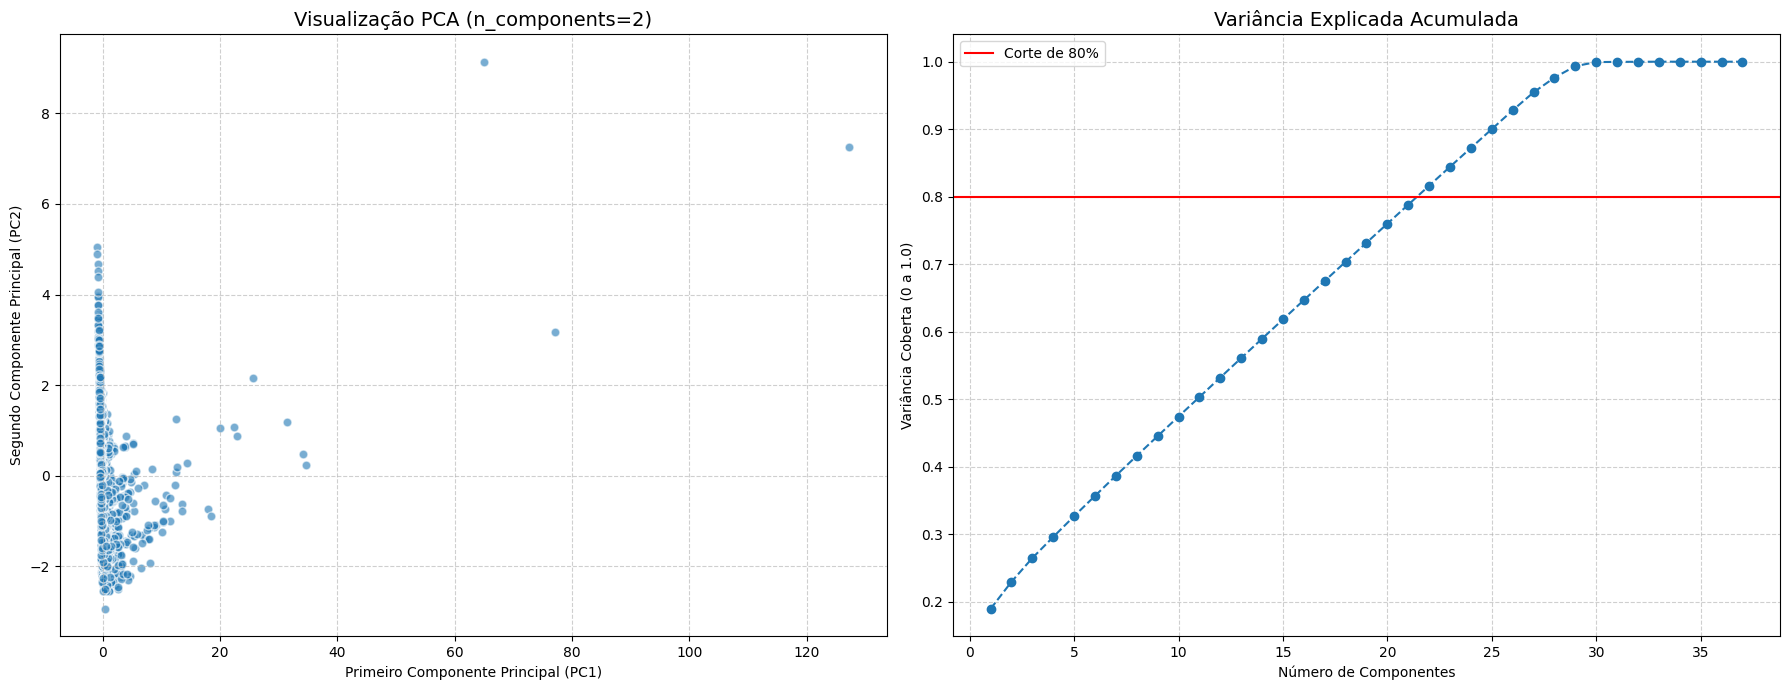

Variância Total com 2 componentes: 22.93%


In [20]:
# Criando a moldura com 1 linha e 2 colunas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Visualização PCA
ax1.scatter(df_scaled_pca[:, 0], df_scaled_pca[:, 1], alpha=0.6, edgecolors='w', s=40)
ax1.set_title('Visualização PCA (n_components=2)', fontsize=14)
ax1.set_xlabel('Primeiro Componente Principal (PC1)')
ax1.set_ylabel('Segundo Componente Principal (PC2)')
ax1.grid(True, linestyle='--', alpha=0.6)

# Vizualização da Variância
ax2.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
ax2.axhline(y=0.80, color='r', linestyle='-', label='Corte de 80%') # Linha de corte
ax2.set_title('Variância Explicada Acumulada', fontsize=14)
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Variância Coberta (0 a 1.0)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

# Ajustando o layout para não sobrepor
plt.tight_layout()
plt.show()

# Print informativo
print(f"Variância Total com 2 componentes: {variancia_acumulada[1]:.2%}")

#### &emsp;  2.2 Aplicação de t-SNE

In [21]:
# Definindo as preplexidades para teste
perplexidades = [20, 30, 50]

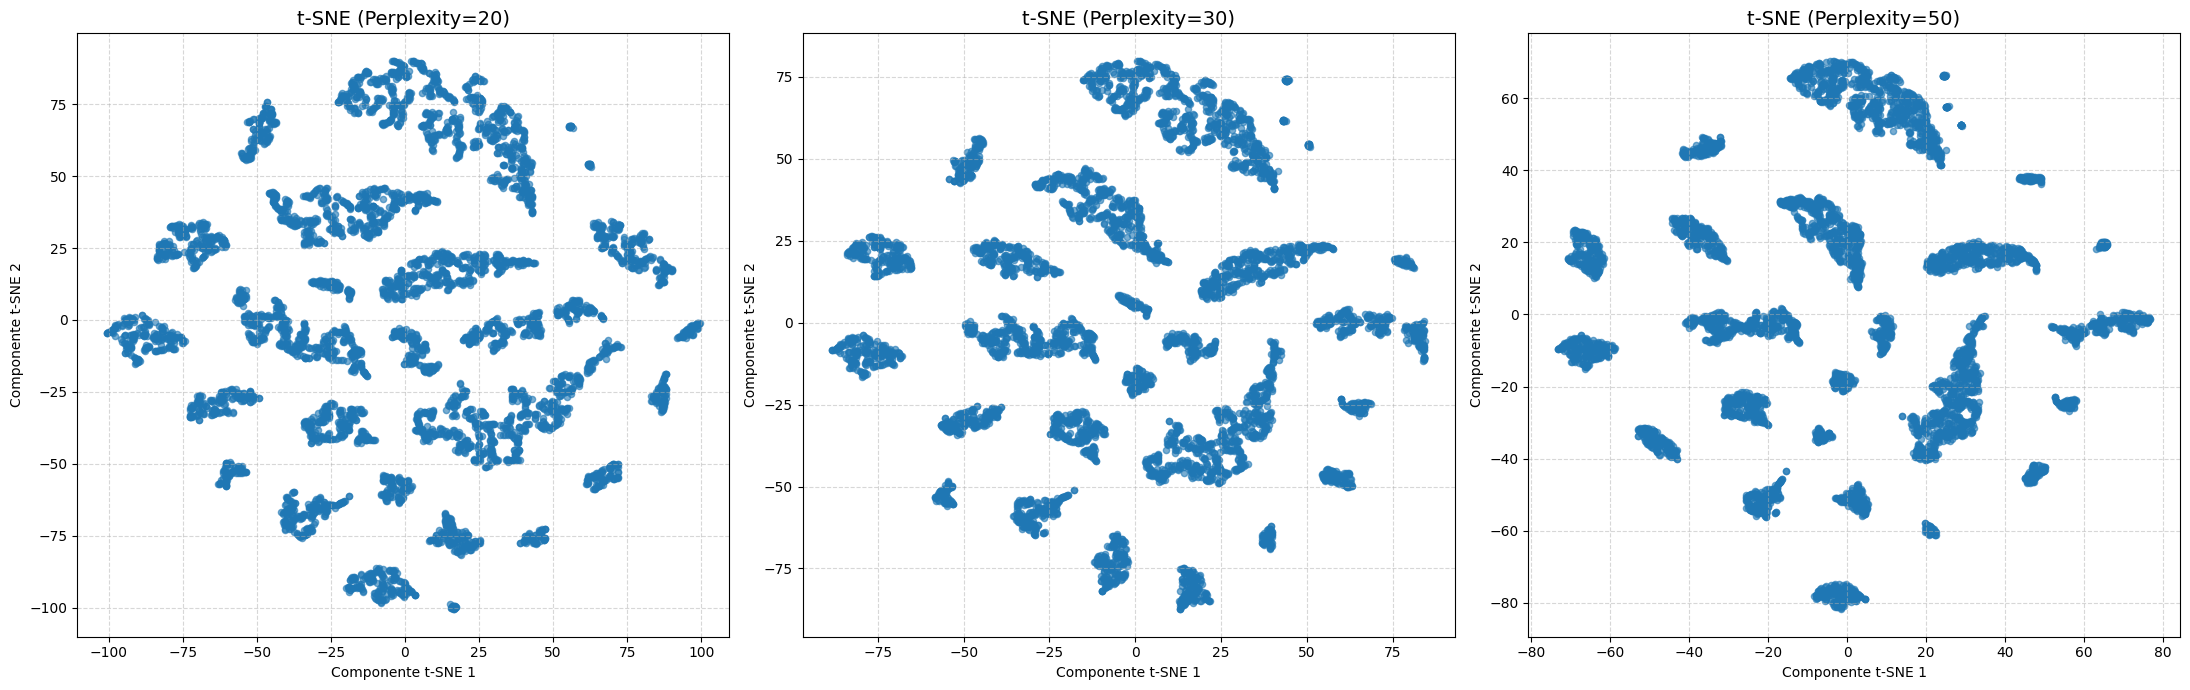

In [22]:
# Criando muldura para as imagnes
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# Adiciona o resultado ao conjunto de resultados
df_reduc['tsne'] = dict()

for i, perp in enumerate(perplexidades):
    # Aplicando o t-SNE (usamos random_state para resultados reproduzíveis)
    tsne = TSNE(n_components=2, perplexity=perp, max_iter=1000, learning_rate=200, random_state=42)
    df_tsne = tsne.fit_transform(df_scaled)

    df_reduc['tsne'][perp] = df_tsne

    # Plotando no subplot correspondente (axes[i])
    axes[i].scatter(df_tsne[:, 0], df_tsne[:, 1], alpha=0.6, s=20)
    axes[i].set_title(f't-SNE (Perplexity={perp})', fontsize=14)
    axes[i].set_xlabel('Componente t-SNE 1')
    axes[i].set_ylabel('Componente t-SNE 2')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Ajusta o espaçamento para os títulos não cortarem
plt.tight_layout()
plt.show()

O t-SNE foi aplicado com o objetivo principal de visualização exploratória. A técnica mostrou-se eficaz em revelar agrupamentos locais, indicando a presença de padrões latentes entre os municípios com comportamentos epidemiológicos semelhantes.

Entretanto, observou-se que:

- A estrutura global dos dados não é preservada;
- Pequenas variações nos parâmetros podem gerar representações distintas;
- O método não é ideal como base direta para algoritmos de clusterização.

Dessa forma, o t-SNE foi utilizado como ferramenta auxiliar, permitindo validar visualmente a existência de possíveis clusters, mas não como espaço final para o agrupamento.

#### &emsp;  2.3 Aplicação de UMAP

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/yb/0t_199hd6xd0c8zshql8663w0000gn/T/ipykernel_38011/379159902.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = axes[i].scatter(df_umap[:, 0], df_umap[:, 1], alpha=0.6, s=15, cmap='viridis')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/yb/0t_199hd6xd0c8zshql8663w0000gn/T/ipykernel_38011/379159902.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = axes[i].scatter(df_umap[:, 0], df_umap[:, 1], alpha=0.6, s=15, cmap='viridis')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3

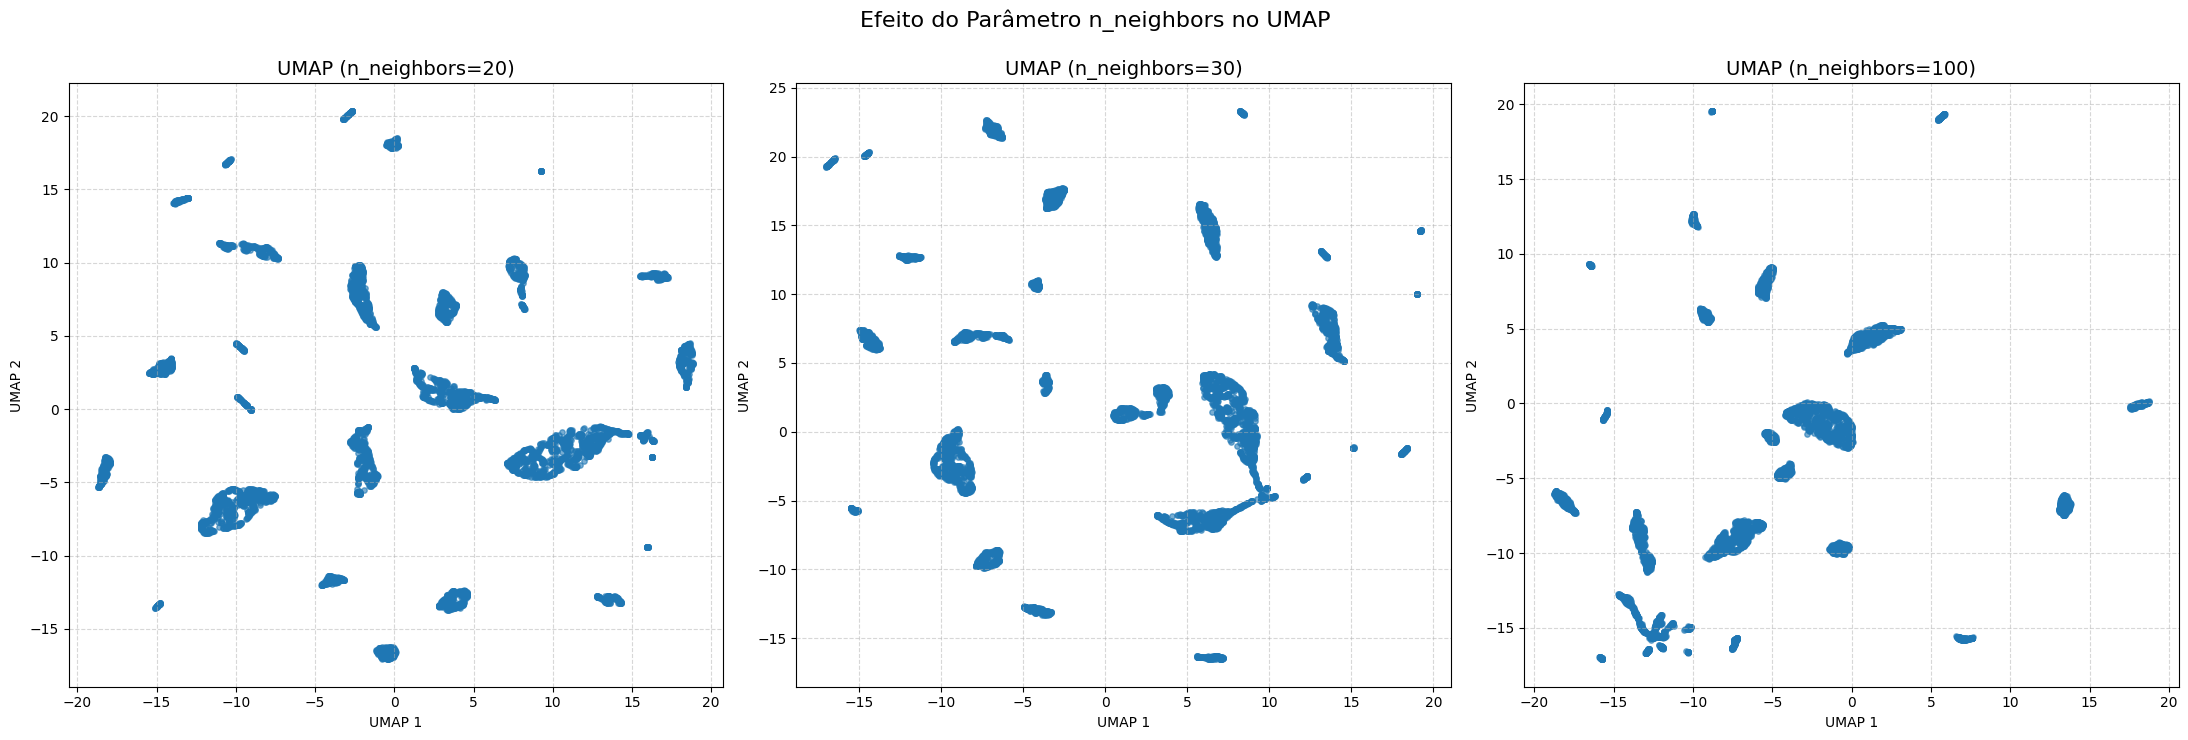

In [60]:
vizinhos = [20, 30, 100]
df_reduc['umap'] = dict()

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

for i, n in enumerate(vizinhos):
    # Aplicando o UMAP
    reducer = umap.UMAP(n_neighbors=n, min_dist=0.1, random_state=42)
    df_umap = reducer.fit_transform(df_scaled)

    # Adiciona o resultado ao conjunto de resultados
    df_reduc['umap'][n] = df_umap

    # Plotando no subplot correspondente
    scatter = axes[i].scatter(df_umap[:, 0], df_umap[:, 1], alpha=0.6, s=15, cmap='viridis')
    axes[i].set_title(f'UMAP (n_neighbors={n})', fontsize=14)
    axes[i].set_xlabel('UMAP 1')
    axes[i].set_ylabel('UMAP 2')
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle('Efeito do Parâmetro n_neighbors no UMAP', fontsize=16, y=1.05)
plt.show()

O UMAP foi aplicado como técnica principal de redução de dimensionalidade. Diferentemente do t-SNE, o UMAP busca preservar tanto as relações locais quanto globais dos dados, além de apresentar maior estabilidade entre execuções.

Nos experimentos realizados, o UMAP gerou um espaço bidimensional no qual os grupos de cidades apresentaram:
- Melhor separação visual;
- Estrutura mais contínua;
- Distribuição mais adequada para algoritmos baseados em distância.

Por essas razões, o UMAP foi adotado como base para a etapa de clusterização.

## 3. Clusterização

Com os dados reduzidos pelo UMAP, foi aplicado o algoritmo K-Means, escolhido por sua simplicidade, eficiência computacional e interpretabilidade.

### &emsp;  3.1 Aplicação de K-Means
Ao aplicar o K-means sobre os dados reduzidos, os clusters obtidos refletem padrões estruturais mais consistentes e interpretáveis, permitindo uma análise mais robusta dos perfis epidemiológicos dos municípios.

A utilização conjunta de **t-SNE e UMAP** tem o objetivo de comparar como cada técnica iria fornecer melhor explicabilidade dos dados em relação aos seus clusters.

In [24]:
df_kmeans_t = df_reduc['tsne'][50]   # <-- Placeholder, liga o df usado a um dos outputs (PCA/t-SNE/UMAP)
df_kmeans_u = df_reduc['umap'][30]

#### 3.1.1 Método do cotovelo

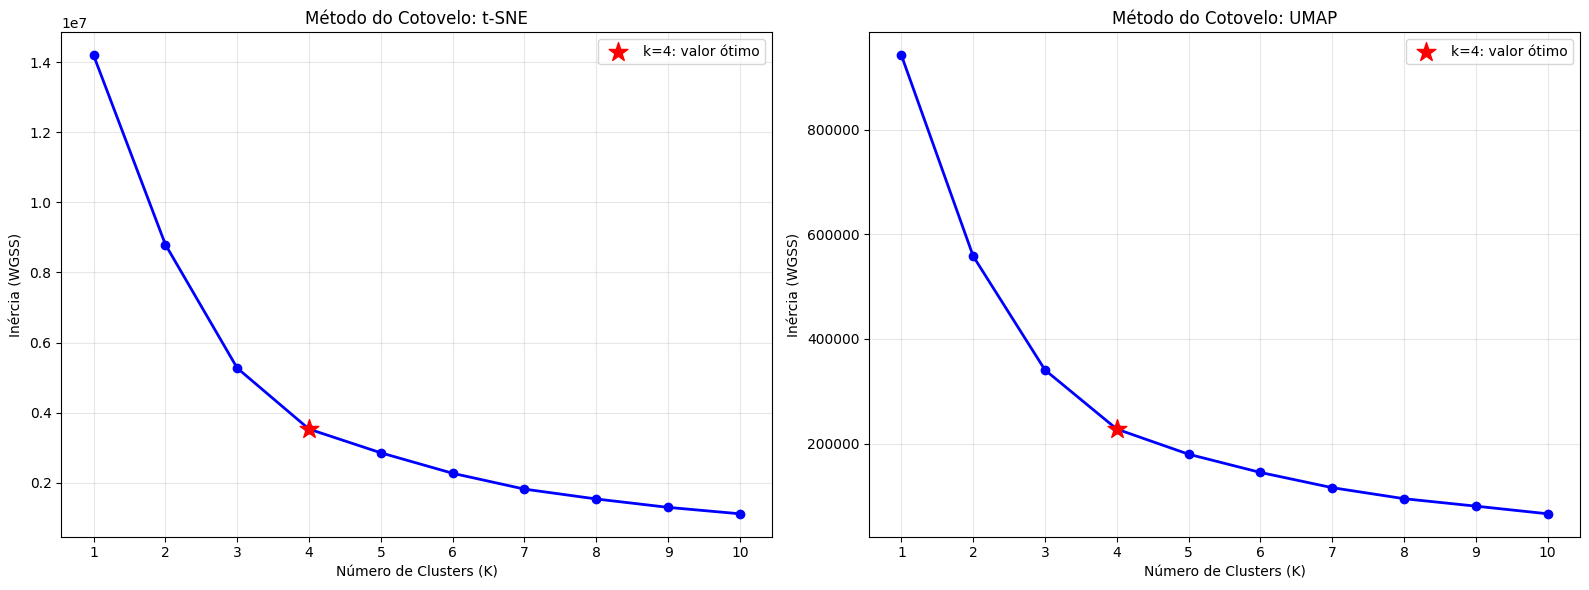

In [25]:
k_range = range(1, 11)
k_target = 4

# Listas para armazenar resultados de ambos
results = {
    'tsne': {'inertias': [], 'data': df_kmeans_t, 'title': 't-SNE'},
    'umap': {'inertias': [], 'data': df_kmeans_u, 'title': 'UMAP'}
}

# Loop de processamento para ambos os datasets
for key in ['tsne', 'umap']:
    data = results[key]['data']

    for k in k_range:
        model = KMeans(n_clusters=k, max_iter=150, random_state=42, n_init=10)
        model.fit(data)

        current_inertia = 0
        for i in range(k):
            cluster_points = data[model.labels_ == i]
            # Cálculo manual da inércia conforme seu código original
            if len(cluster_points) > 0:
                current_inertia += np.sum((cluster_points - model.cluster_centers_[i])**2)

        results[key]['inertias'].append(current_inertia)

# Plotagem lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, key in enumerate(['tsne', 'umap']):
    inertias = results[key]['inertias']

    axes[i].plot(k_range, inertias, 'bo-', linewidth=2)
    axes[i].set_xlabel('Número de Clusters (K)')
    axes[i].set_ylabel('Inércia (WGSS)')
    axes[i].set_title(f'Método do Cotovelo: {results[key]["title"]}')
    axes[i].set_xticks(k_range)
    axes[i].grid(True, alpha=0.3)

    # Marcar o ponto escolhido (k=4)
    if k_target in k_range:
        y_target = inertias[k_target - 1]
        axes[i].scatter(k_target, y_target, marker='*', color='red', s=200, zorder=5, label=f'k={k_target}: valor ótimo')
        axes[i].legend()

plt.tight_layout()
plt.show()

A escolha do número de clusters (k) foi orientada por:
- Método do cotovelo (elbow method);
- Comparação visual entre diferentes valores de k;
- Coerência e separação dos grupos formados.

Foram testados valores de k = 4, 5 e 6, sendo observado que k = 4 apresentou o melhor equilíbrio entre:
- Coesão intra-cluster;
- Separação inter-cluster;
- Facilidade de interpretação.

Assim, o modelo final de K-Means foi ajustado com 4 clusters.

In [26]:
# Aplicação do k-means com k=4 e redução com t-SNE
kmeans = KMeans(n_clusters=4, max_iter=500, random_state=42)
kmeans.fit(df_kmeans_t)
kmeans_labels_t = kmeans.labels_

In [27]:
# Aplicação do k-means com k=4 e redução com UMAP
kmeans = KMeans(n_clusters=4, max_iter=500, random_state=42)
kmeans.fit(df_kmeans_u)
kmeans_labels_u = kmeans.labels_

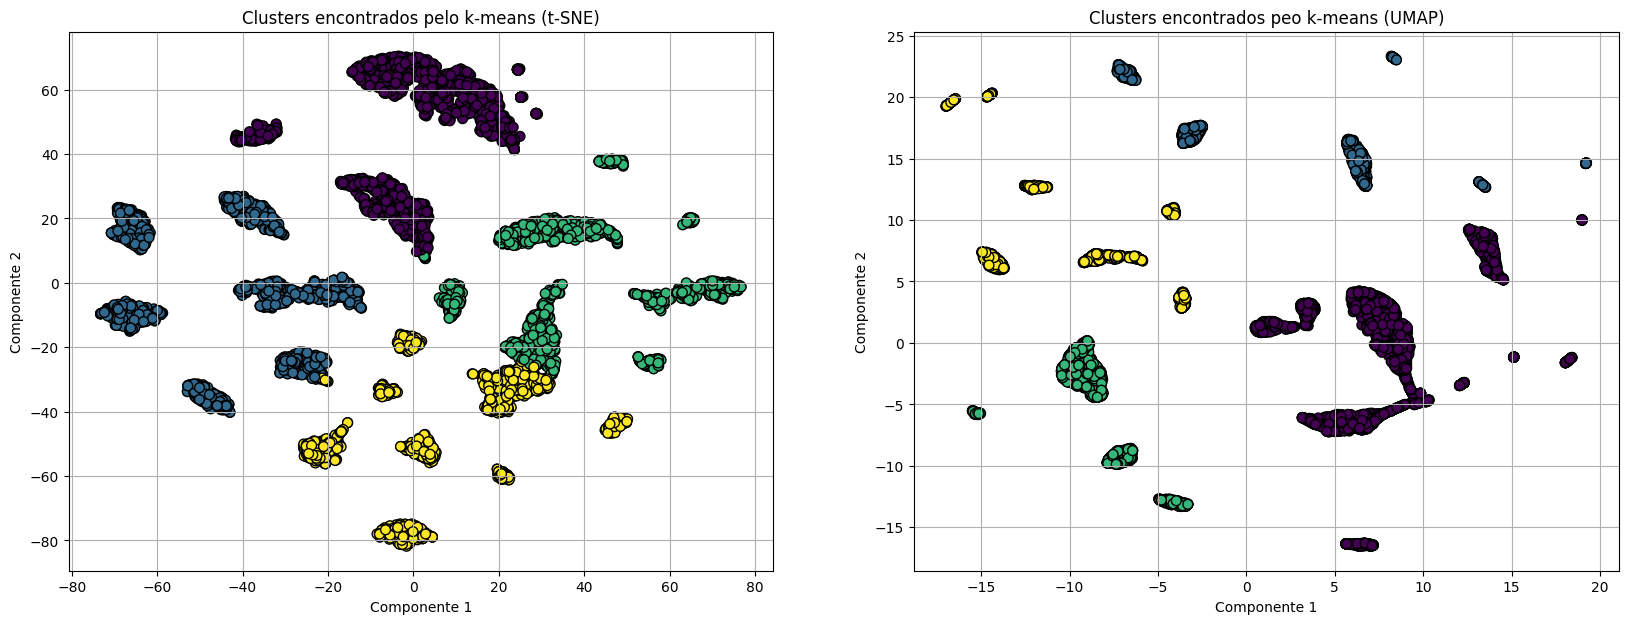

In [28]:
fig, axes = plt.subplots(1,2, figsize=(20,7))

# Plot 1: Agrupamento do k-means com t-SNE
axes[0].scatter(df_kmeans_t[:, 0], df_kmeans_t[:, 1], c=kmeans_labels_t, s=50, cmap='viridis', edgecolor='k')
axes[0].set_title("Clusters encontrados pelo k-means (t-SNE)")
axes[0].set_xlabel('Componente 1')
axes[0].set_ylabel('Componente 2')
axes[0].grid(True)

# Plot 2: Agrupamento do k-means com UMAP
scatter = axes[1].scatter(df_kmeans_u[:, 0], df_kmeans_u[:, 1], c=kmeans_labels_u, s=50, cmap='viridis', edgecolor='k')
axes[1].set_title("Clusters encontrados peo k-means (UMAP)")
axes[1].set_xlabel('Componente 1')
axes[1].set_ylabel('Componente 2')
axes[1].grid(True)

A aplicação do K-Means sobre o espaço reduzido pelo UMAP resultou em quatro grupos distintos de municípios, representando diferentes perfis epidemiológicos relacionados à COVID-19.

A visualização dos clusters mostrou:
- Boa separação espacial entre os grupos;
- Baixa sobreposição entre clusters;
- Centróides bem definidos.

Esses resultados indicam que o UMAP + K-Means foram capazes de capturar padrões relevantes presentes nos dados originais.

### &emsp;  3.2 Aplicação de DBSCAN

O algoritmo DBSCAN também foi considerado como alternativa ao K-Means, por sua capacidade de identificar clusters baseados em densidade e detectar automaticamente ruídos.

No entanto, nos testes realizados, o DBSCAN apresentou limitações relevantes:
- Sensibilidade elevada à escolha do parâmetro eps;
- Classificação de uma grande quantidade de municípios como ruído;
- Dificuldade em lidar com regiões de densidade variável no espaço reduzido.

Em comparação, o K-Means apresentou resultados mais estáveis e interpretáveis, especialmente após a redução de dimensionalidade com o UMAP.

In [29]:
df_dbscan_t = df_reduc['tsne'][50]
df_dbscan_u = df_reduc['umap'][30]

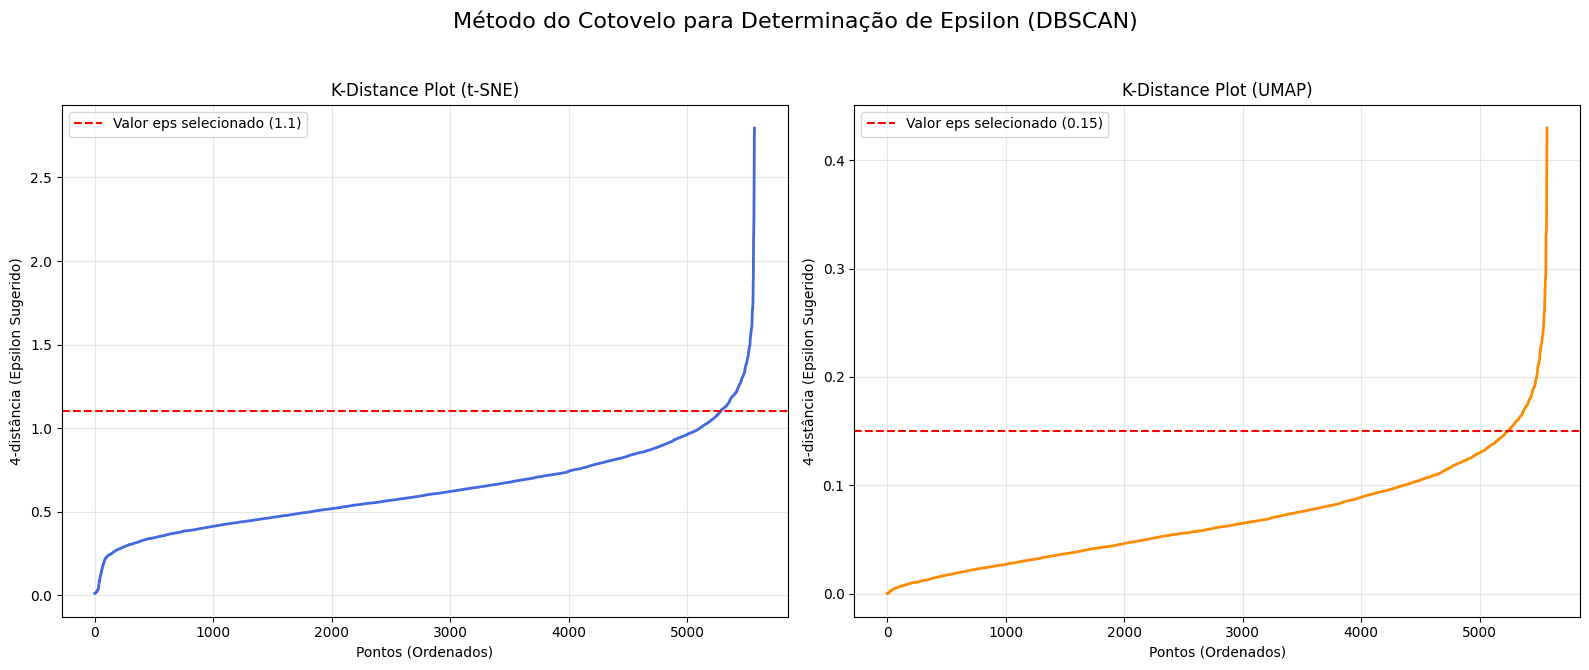

In [30]:
min_pts = 5
k = min_pts - 1
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

#t-SNE
nn_t = NearestNeighbors(n_neighbors=k + 1, metric="euclidean")
nn_t.fit(df_dbscan_t)
distances_t, _ = nn_t.kneighbors(df_dbscan_t)
kth_distances_t = np.sort(distances_t[:, k])

eps_sel_t = 1.1

axes[0].plot(range(len(kth_distances_t)), kth_distances_t, linewidth=2, color='royalblue')
axes[0].axhline(y=eps_sel_t, color='red', linestyle='--', linewidth=1.5, label=f'Valor eps selecionado ({eps_sel_t})')
axes[0].set_title("K-Distance Plot (t-SNE)")
axes[0].set_xlabel("Pontos (Ordenados)")
axes[0].set_ylabel(f"{k}-distância (Epsilon Sugerido)")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# UMAP
nn_u = NearestNeighbors(n_neighbors=k + 1, metric="euclidean")
nn_u.fit(df_dbscan_u)
distances_u, _ = nn_u.kneighbors(df_dbscan_u) # Corrigido para nn_u
kth_distances_u = np.sort(distances_u[:, k])

eps_sel_u = 0.15

axes[1].plot(range(len(kth_distances_u)), kth_distances_u, linewidth=2, color='darkorange')
axes[1].axhline(y=eps_sel_u, color='red', linestyle='--', linewidth=1.5, label=f'Valor eps selecionado ({eps_sel_u})')
axes[1].set_title("K-Distance Plot (UMAP)")
axes[1].set_xlabel("Pontos (Ordenados)")
axes[1].set_ylabel(f"{k}-distância (Epsilon Sugerido)")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.suptitle('Método do Cotovelo para Determinação de Epsilon (DBSCAN)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

O K-Distance Plot é utilizado para encontrar o parâmetro eps (raio de vizinhança) ideal para o algoritmo DBSCAN.

Text(0, 0.5, 'Componente 2')

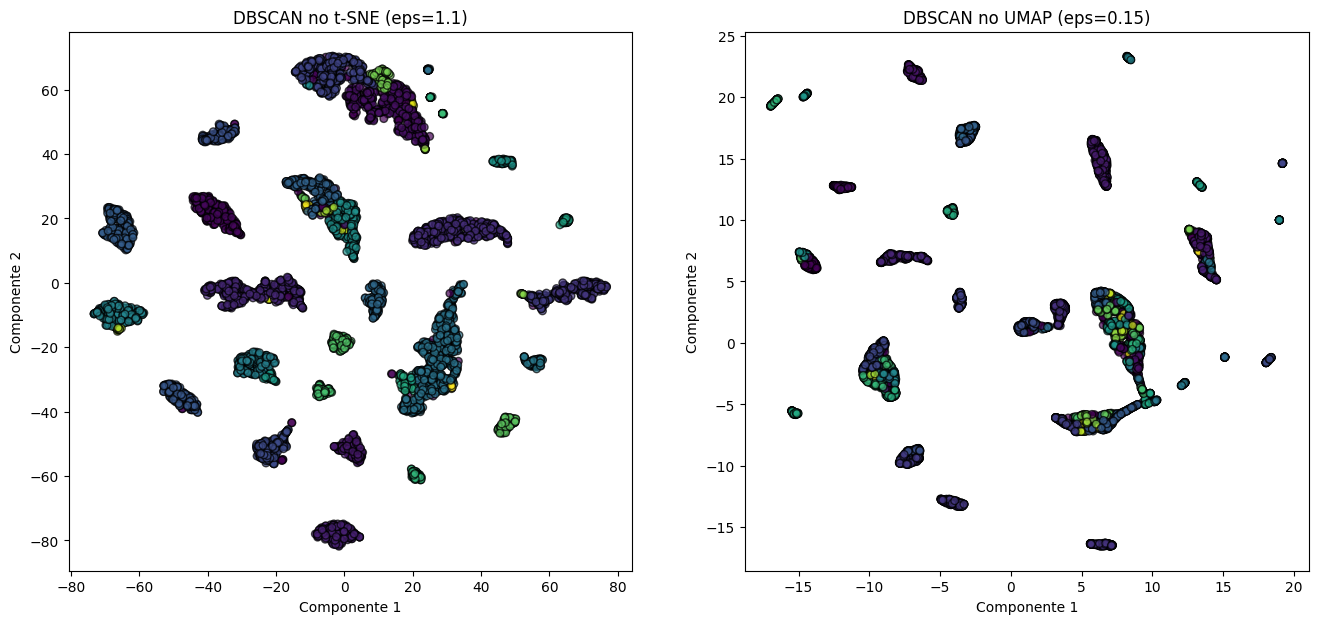

In [31]:
# Configurando os modelos com os valores de eps que você selecionou
dbscan_t = DBSCAN(eps=eps_sel_t, min_samples=min_pts)
dbscan_u = DBSCAN(eps=eps_sel_u, min_samples=min_pts)

# Ajustando aos dados
labels_t = dbscan_t.fit_predict(df_dbscan_t)
labels_u = dbscan_u.fit_predict(df_dbscan_u)

# Plotagem dos resultados
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

#Gráfico para t-SNE
scatter_t = axes[0].scatter(df_dbscan_t[:, 0], df_dbscan_t[:, 1], c=labels_t,
                            cmap='viridis', s=30, edgecolor='k', alpha=0.7)
axes[0].set_title(f"DBSCAN no t-SNE (eps={eps_sel_t})")
axes[0].set_xlabel("Componente 1")
axes[0].set_ylabel("Componente 2")

# Gráfico para UMAP
scatter_u = axes[1].scatter(df_dbscan_u[:, 0], df_dbscan_u[:, 1], c=labels_u,
                            cmap='viridis', s=30, edgecolor='k', alpha=0.7)
axes[1].set_title(f"DBSCAN no UMAP (eps={eps_sel_u})")
axes[1].set_xlabel("Componente 1")
axes[1].set_ylabel("Componente 2")

## 4. Discussão de resultados

In [59]:
# PCA
labels_pca = KMeans(n_clusters=k, random_state=42).fit_predict(df_scaled_pca)
sil_pca = silhouette_score(df_scaled_pca, labels_pca)

# t-SNE
X_tsne = df_reduc['tsne'][50]
labels_tsne = KMeans(n_clusters=k, random_state=42).fit_predict(X_tsne)
sil_tsne = silhouette_score(X_tsne, labels_tsne)

# UMAP
X_umap = df_reduc['umap'][30]
labels_umap = KMeans(n_clusters=k, random_state=42).fit_predict(X_umap)
sil_umap = silhouette_score(X_umap, labels_umap)

print(f"Silhueta PCA:  {sil_pca:.4f}")
print(f"Silhueta t-SNE:{sil_tsne:.4f}")
print(f"Silhueta UMAP: {sil_umap:.4f}")

Silhueta PCA:  0.5115
Silhueta t-SNE:0.4244
Silhueta UMAP: 0.4694


Com base nos experimentos realizados, a abordagem UMAP + K-Means (k = 4) mostrou-se a mais adequada para este conjunto de dados, pois:

- Produziu clusters bem definidos;
- Facilitou a interpretação dos perfis epidemiológicos;
- Apresentou maior estabilidade em relação ao DBSCAN;
- Apresentou melhor desemprenho no teste de Silhueta UMAP: 0.4694;
- Obteve melhor desempenho visual e estrutural no espaço reduzido.

O t-SNE foi mantido como ferramenta complementar de visualização, enquanto o UMAP foi utilizado como método principal para suportar a clusterização.

### 4.1 Caracterização dos Clusters

Cluster 1 (Zonas de Alto Impacto e Epicentros): Este é o grupo mais crítico do estudo. Ele concentra o maior volume absoluto de perdas, ultrapassando 300.000 mortes acumuladas. Com uma média de 181,1 mortes por município e a maior média de casos (5.872), este cluster representa as cidades que foram o motor da pandemia no país.

Cluster 2 (Impacto Moderado-Alto): Composto por 1.069 municípios, este grupo apresenta uma intensidade intermediária. A média de mortes por cidade é de 54,1, indicando locais que enfrentaram crises severas, mas em uma escala controlada se comparada ao primeiro grupo.

Clusters 0 e 3 (Impacto Baixo e Estabilizado): Estes grupos reúnem municípios com os menores indicadores. O Cluster 3, por exemplo, apresenta a menor média de óbitos (28,8). São cidades que, apesar da pandemia, mantiveram números totais significativamente mais baixos, possivelmente devido à menor densidade populacional ou isolamento geográfico.

In [51]:
df_analysis = df.copy()
df_analysis['label_kmeans_u'] = pd.Series(kmeans_labels_u)

In [52]:
analise_cluster = df_analysis.groupby('label_kmeans_u').agg({
    'total_cases': ['sum', 'mean', 'count'], 
    'total_deaths': ['sum', 'mean']
})

In [54]:
analise_cluster.columns = [ 'Soma_Casos', 'Media_Casos', 'N_municipios', 'Soma_Mortes', 'Media_Mortes']

In [55]:
analise_cluster.reset_index()

,label_kmeans_u,Soma_Casos,Media_Casos,N_municipios,Soma_Mortes,Media_Mortes
0,0,10814260.0,4165.739599,2596,324758,125.099384
1,1,1423084.0,1584.726058,898,30704,34.191537
2,2,1685879.0,1580.017807,1067,44268,41.488285
3,3,2164121.0,2144.817641,1009,58395,57.874133


/var/folders/yb/0t_199hd6xd0c8zshql8663w0000gn/T/ipykernel_38011/917424489.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=analise_cluster.index, y='Soma_Casos', data=analise_cluster, ax=axes[0,0], palette='Blues_d')
/var/folders/yb/0t_199hd6xd0c8zshql8663w0000gn/T/ipykernel_38011/917424489.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=analise_cluster.index, y='Media_Casos', data=analise_cluster, ax=axes[0,1], palette='Blues_d')
/var/folders/yb/0t_199hd6xd0c8zshql8663w0000gn/T/ipykernel_38011/917424489.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the 

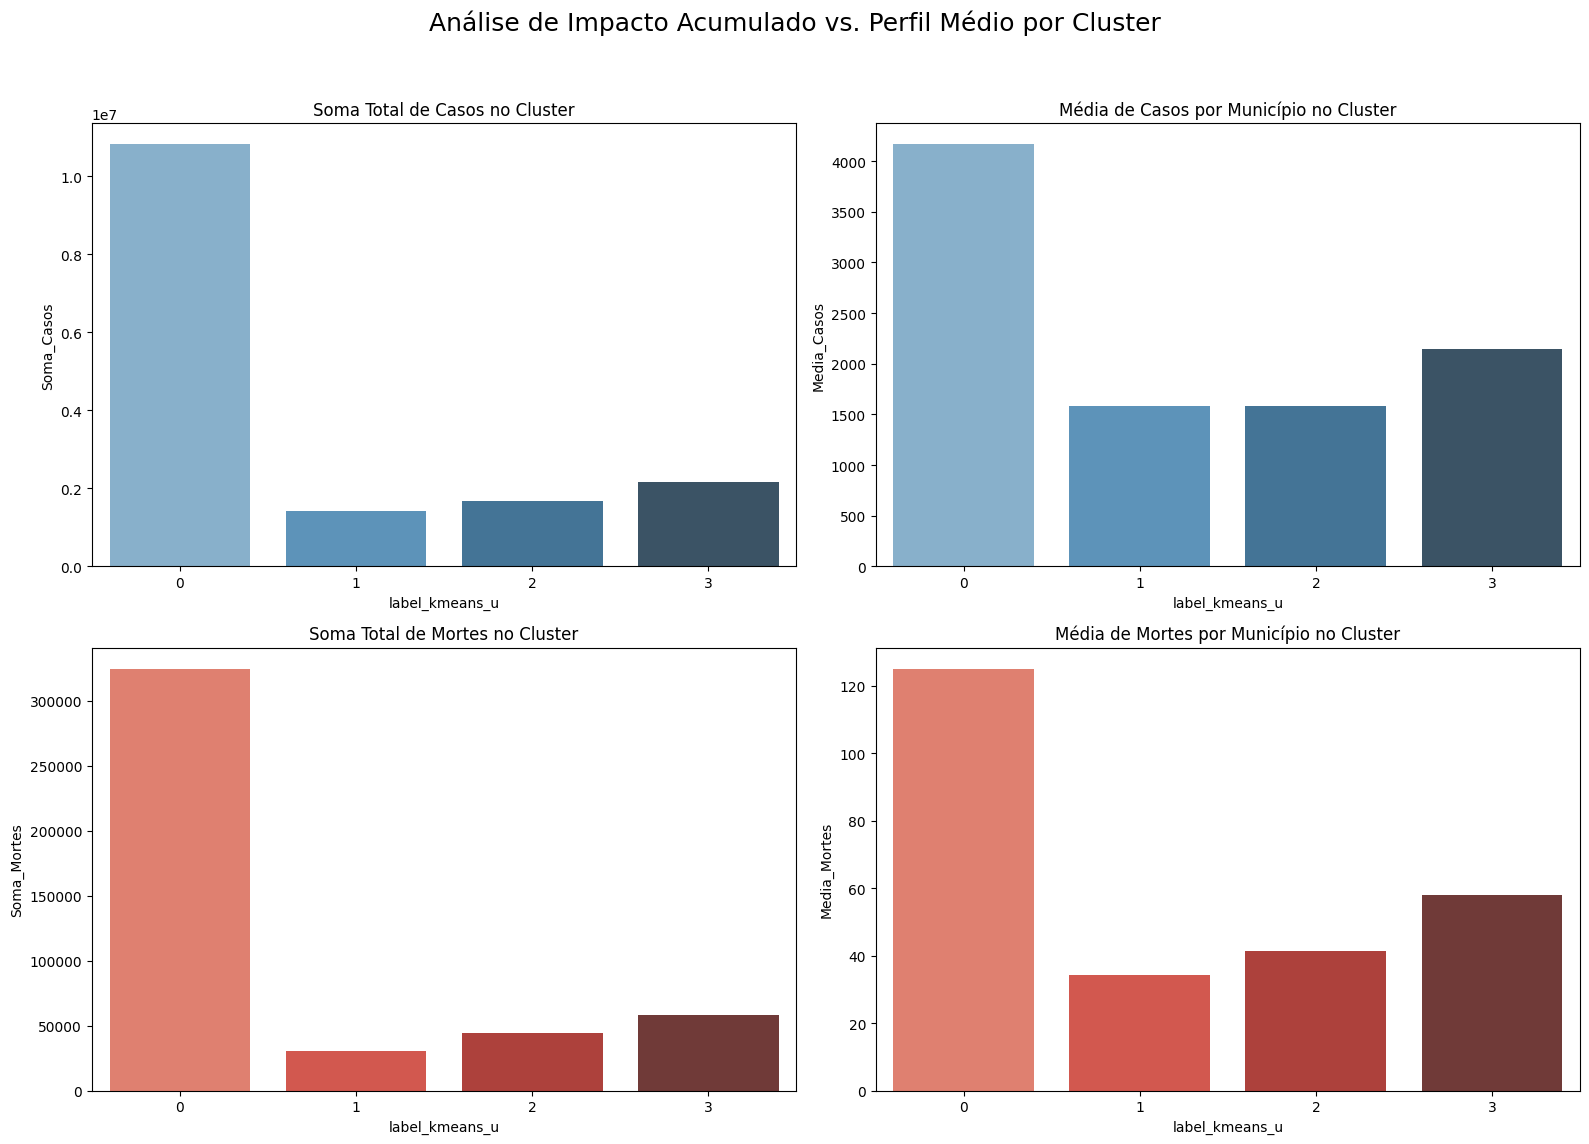

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#Plotando graficos de casos
sns.barplot(x=analise_cluster.index, y='Soma_Casos', data=analise_cluster, ax=axes[0,0], palette='Blues_d')
axes[0,0].set_title('Soma Total de Casos no Cluster')

sns.barplot(x=analise_cluster.index, y='Media_Casos', data=analise_cluster, ax=axes[0,1], palette='Blues_d')
axes[0,1].set_title('Média de Casos por Município no Cluster')

sns.barplot(x=analise_cluster.index, y='Soma_Mortes', data=analise_cluster, ax=axes[1,0], palette='Reds_d')
axes[1,0].set_title('Soma Total de Mortes no Cluster')

sns.barplot(x=analise_cluster.index, y='Media_Mortes', data=analise_cluster, ax=axes[1,1], palette='Reds_d')
axes[1,1].set_title('Média de Mortes por Município no Cluster')

plt.suptitle('Análise de Impacto Acumulado vs. Perfil Médio por Cluster', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

A tabela mostra que a sua intuição sobre o Cluster 0 ser composto pelas grandes metrópoles estava correta, mas com uma nuance importante: ele é, de longe, o maior grupo em número de cidades (2.596 municípios).

- Cluster 0 (Alta Criticidade e Volume): Concentra a vasta maioria das ocorrências, com mais de 10,8 milhões de casos e 324 mil mortes. A média de 125 mortes por município confirma que este grupo lida com a maior pressão sobre o sistema de saúde.

- Cluster 3 (Cidades de Médio Porte): Possui 1.009 municípios e apresenta a segunda maior média de casos (2.144) e mortes (57,8). Representa as cidades polo que servem como suporte regional.

- Clusters 1 e 2 (Baixo Impacto): Somam quase 2.000 municípios. O Cluster 2 tem um volume total ligeiramente maior que o Cluster 1 porque possui mais cidades (1.067 vs 898), mas ambos mantêm o perfil de menor impacto médio.

### &emsp; 4.1.1 Sobre os dados

Queriamos entender como e se existiam padrões epidemiológicos distintos entre os municípios brasileiros. A análise realizada demonstrou que os municípios brasileiros não apresentam um comportamento epidemiológico **homogêneo** em relação à COVID-19.

A aplicação de técnicas de aprendizado de máquina não supervisionado permitiu identificar **padrões epidemiológicos distintos**, revelando que os municípios se organizam naturalmente em **quatro grupos principais** com características semelhantes quando consideradas múltiplas variáveis simultaneamente.

Esses agrupamentos indicam a existência de perfis epidemiológicos bem definidos, os quais **não seriam facilmente identificados por meio de análises univariadas ou observações isoladas das variáveis.**


# 5. Conclusão


Os resultados obtidos demonstram que a redução de dimensionalidade é uma etapa essencial em problemas de clusterização envolvendo dados complexos e de alta dimensão.

A utilização do UMAP permitiu a construção de um espaço latente mais informativo, no qual o K-Means foi capaz de identificar padrões epidemiológicos distintos entre os municípios brasileiros.

Essa abordagem evidenciou que a combinação adequada entre técnicas de pré-processamento, redução de dimensionalidade e clusterização é determinante para o sucesso de métodos de aprendizado não supervisionado.

Alunos: Douglas Nunes, Gabriel Garcia, Joamerson, Nathalia 
Professores: Silvan e Leonardo
Aprendizado de Máquina Não-Supervisionado 2025.4 - UFRN